## Preparing the Data

In [4]:
import pandas as pd
import numpy as np

In [5]:
icd9_code = pd.read_csv("./Data/DIAGNOSES_ICD.csv", index_col = None)

In [6]:
n_rows = 100000

# create the iterator
noteevents_iterator = pd.read_csv(
    "./Data/NOTEEVENTS.csv",
    iterator=True,
    chunksize=n_rows)

# concatenate according to a filter to get our noteevents data
noteevents = pd.concat(
    [noteevents_chunk[np.logical_and(noteevents_chunk.CATEGORY.isin(["Discharge summary"]),
                                     noteevents_chunk.DESCRIPTION.isin(["Report"]))]
    for noteevents_chunk in noteevents_iterator])
noteevents.HADM_ID = noteevents.HADM_ID.astype(int)

c:\users\bansa\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
try:
    assert len(noteevents.drop_duplicates(["SUBJECT_ID","HADM_ID"])) == len(noteevents)
except AssertionError as e:
    print("There are duplicates on Primary Key Set")

There are duplicates on Primary Key Set


In [8]:
# Seeing if discharge summaries are different for repeating (SUBJECT_ID, HADM_ID) pair.
pd.set_option('display.max_colwidth',1)
noteevents[noteevents.duplicated(subset = ["SUBJECT_ID","HADM_ID"], keep = False)].sort_values(["SUBJECT_ID"])[['SUBJECT_ID', 'HADM_ID', 'TEXT']].head(2)

SUBJECT_ID  HADM_ID  \
9214  18          188822    
9215  18          188822    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [9]:
noteevents.CHARTDATE  = pd.to_datetime(noteevents.CHARTDATE , format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [10]:
pd.set_option('display.max_colwidth',50)
noteevents.sort_values(["SUBJECT_ID","HADM_ID","CHARTDATE"], inplace =True)
noteevents.drop_duplicates(["SUBJECT_ID","HADM_ID"], inplace = True)

noteevents.reset_index(drop = True, inplace = True)

In [11]:
top_values = (icd9_code.groupby('ICD9_CODE').
              agg({"SUBJECT_ID": "nunique"}).
              reset_index().sort_values(['SUBJECT_ID'], ascending = False).ICD9_CODE.tolist()[:15])

In [12]:
icd9_code = icd9_code[icd9_code.ICD9_CODE.isin(top_values)]

In [13]:
import re
import itertools

def clean_text(text):
    return [x for x in list(itertools.chain.from_iterable([t.split("<>") for t in text.replace("\n"," ").split("|")])) if len(x) > 0]


most_frequent_tags = [re.match("^(.*?):",x).group() for text in noteevents.TEXT for x in text.split("\n\n") if pd.notnull(re.match("^(.*?):",x))]
pd.Series(most_frequent_tags).value_counts().head(10)

Admission Date:                          51704
Date of Birth:                           44491
Service:                                 44219
Allergies:                               38198
Attending:                               38060
Discharge Diagnosis:                     37863
Major Surgical or Invasive Procedure:    34285
Physical Exam:                           28767
Followup Instructions:                   28401
Facility:                                24265
dtype: int64

In [14]:
irrelevant_tags = ["Admission Date:", "Date of Birth:", "Service:", "Attending:", "Facility:", "Medications on Admission:", "Discharge Medications:", "Completed by:",
"Dictated By:" , "Department:" , "Provider:"]

updated_text = ["<>".join(["|".join(re.split("\n\d|\n\s+",re.sub("^(.*?):","",x).strip())) for x in text.split("\n\n") if pd.notnull(re.match("^(.*?):",x)) and re.match("^(.*?):",x).group() not in irrelevant_tags ]) for text in noteevents.TEXT]
updated_text = [re.sub("(\[.*?\])", "", text) for text in updated_text]

updated_text = ["|".join(clean_text(x)) for x in updated_text]

In [15]:
noteevents["CLEAN_TEXT"] = updated_text

In [16]:
# text = """Admission Date: [**2118-6-2**] Discharge Date: [**2118-6-14**]

# Date of Birth: Sex: F

# Service: MICU and then to [**Doctor Last Name **] Medicine

# HISTORY OF PRESENT ILLNESS: This is an 81-year-old female
# with a history of emphysema (not on home O2), who presents
# with three days of shortness of breath thought by her primary
# care doctor to be a COPD flare. Two days prior to admission,
# she was started on a prednisone taper and one day prior to
# admission she required oxygen at home in order to maintain
# oxygen saturation greater than 90%. She has also been on
# levofloxacin and nebulizers, and was not getting better, and
# presented to the [**Hospital1 18**] Emergency Room.

# In the [**Hospital3 **] Emergency Room, her oxygen saturation was
# 100% on CPAP. She was not able to be weaned off of this
# despite nebulizer treatment and Solu-Medrol 125 mg IV x2.

# Review of systems is negative for the following: Fevers,
# chills, nausea, vomiting, night sweats, change in weight,
# gastrointestinal complaints, neurologic changes, rashes,
# palpitations, orthopnea. Is positive for the following:
# Chest pressure occasionally with shortness of breath with
# exertion, some shortness of breath that is positionally
# related, but is improved with nebulizer treatment."""

# updated_t = "<>".join(["|".join(re.split("\n\d|\n\s+",re.sub("^(.*?):","",x).strip())) for x in text.split("\n\n") if pd.notnull(re.match("^(.*?):",x)) and re.match("^(.*?):",x).group() not in irrelevant_tags ])
# updated_t = re.sub("(\[.*?\])", "", updated_t)
# updated_t = "|".join(clean_text(updated_t))
# updated_t.split("|")

# Training Multi-Label Model

In [17]:
# !pip install scispacy

In [18]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import tensorflow as tf

# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split

In [19]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizerFast.from_pretrained('dmis-lab/biobert-large-cased-v1.1')

In [20]:
vocab = tokenizer.vocab.keys()

In [18]:
# Total Length
print("Total Length of Vocabulary words are : ", len(vocab))

Total Length of Vocabulary words are :  58996


In [5]:
import spacy
import scispacy

from scispacy.linking import EntityLinker
nlp = spacy.load('en_core_sci_lg')

In [6]:
linker = EntityLinker(resolve_abbreviations=False, name="umls") # keeping default thresholds for match percentage.
nlp.add_pipe(linker)

C:\Users\bansa\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\bansa\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
target_vocab = [word[2:] for word in vocab if "##" in word and (len(word[2:]) > 3)] + [word[2:] for word in vocab if "##" not in word and (len(word) > 3)]

In [14]:
umls_concept_extracted = [[umls_ent for entity in doc.ents for umls_ent in entity._.umls_ents] for doc in nlp.pipe(target_vocab)]

In [54]:
umls_concept_cui = [linker.kb.cui_to_entity[concepts[0][0]] for concepts in umls_concept_extracted if len(concepts) > 0]
# Capturing all the information shared from the UMLS DB in a dataframe
umls_concept_df = pd.DataFrame(umls_concept_cui)

In [53]:
# umls_concept_df.to_csv("umls_concepts.csv", index = None)

In [33]:
# UMLs provides a class name to each of its TXXX identifier, TXXX is code for parents for each of the CUI numbers a unique concept
# identifier used by UMLs Kb

# To obtain this file please login to https://www.nlm.nih.gov/research/umls/index.html
# Shared in Github Repo of the book :)
type2namemap = pd.read_csv("SRDEF", sep ="|", header = None)
type2namemap = type2namemap.iloc[:,:3]
type2namemap.columns = ["ClassType","TypeID","TypeName"]
typenamemap = {row["TypeID"]:row["TypeName"] for i,row in type2namemap.iterrows()}

In [55]:
concept_df = pd.Series([typenamemap[typeid] for types in umls_concept_df.types for typeid in types]).value_counts().reset_index()
concept_df.columns = ["concept","count"]

In [62]:
import plotly.express as px
fig = px.pie(concept_df.head(20), values='count', names='concept', title='Count of Biomedical Concepts in BERT Pre-trained Model')
fig.show()

In [44]:
# Multiple counting is very less as most of the concepts have single TXXX id mapped to it.
pd.Series([len(types) for types in umls_concept_df.types]).value_counts()

1    16962
2     1629
3      328
dtype: int64

In [9]:
import pickle
with open('linker_umls.pickle', 'wb') as handle:
    pickle.dump(umls_concept_extracted, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
subword_len = [len(x.replace("##","")) for x in vocab]
token_len = [len(x) for x in vocab]

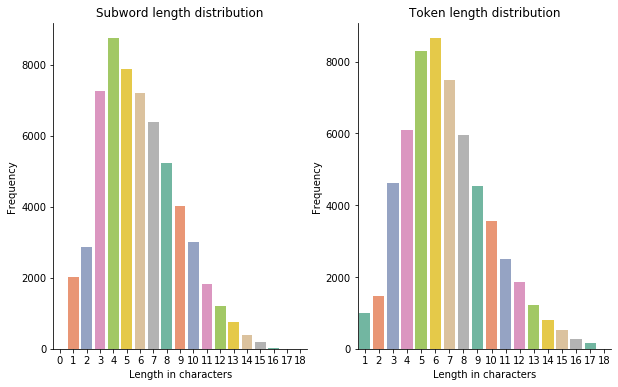

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

with sns.plotting_context(font_scale=2):
    fig, axes = plt.subplots(1,2, figsize=(10, 6))
    sns.countplot(subword_len, palette="Set2", ax=axes[0])
    sns.despine()
    axes[0].set_title("Subword length distribution")
    axes[0].set_xlabel("Length in characters")
    axes[0].set_ylabel("Frequency")
    
    sns.countplot(token_len, palette="Set2", ax=axes[1])
    sns.despine()
    axes[1].set_title("Token length distribution")
    axes[1].set_xlabel("Length in characters")
    axes[1].set_ylabel("Frequency")

## Preparing the Data

In [21]:
# Making icd9_code unique at SUBJECT ID and HADM_ID level by clubbing different ICD9_CODE
icd9_code = icd9_code.groupby(["SUBJECT_ID","HADM_ID"])["ICD9_CODE"].apply(list).reset_index()

full_data = pd.merge(noteevents, icd9_code, how="left", on = ["SUBJECT_ID","HADM_ID"])

# Removing any SUBJECT_ID and HADM_ID pair not having the top 15 ICD9 Codes
full_data = full_data.dropna(subset = ["ICD9_CODE"]).reset_index(drop = True)

# Make sure we have text of considerable length
full_data.CLEAN_TEXT = [" ".join([y for y in x.split("|") if len(y.split()) > 3]) for x in full_data.CLEAN_TEXT]

full_data.ICD9_CODE = full_data.ICD9_CODE.apply(lambda x : "|".join(x))

In [36]:
# full_data.to_csv("./data.csv", index = None)

In [30]:
# Binarizing the multi- labels
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

mlb = MultiLabelBinarizer()
mlb_fit = mlb.fit(full_data.ICD9_CODE.tolist())

train_X,val_X,train_y,val_y = train_test_split(full_data[["SUBJECT_ID","HADM_ID","CLEAN_TEXT"]],full_data.ICD9_CODE.values,
                                              test_size=0.2, random_state=42)

In [39]:
full_data

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,CLEAN_TEXT,ICD9_CODE
0,44005,3,145834,2101-10-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...,Admitted from rehabilitation for hypotension (...,5849|4280
1,20825,6,107064,2175-06-15,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2175-5-30**] Dischar...,The patient is a 65 year-old woman with end st...,2859
2,20070,9,150750,2149-11-13,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2149-11-9**] Dischar...,"Weakness, inability to talk. This is a 41-year...",4280|5849|4019
3,17390,10,184167,2103-07-06,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2103-6-28**] Dischar...,"Baby Girl is a 1,385 gram, former 30 and wee...",V290
4,50972,12,112213,2104-08-20,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2104-8-7**] Discharge ...,2-year-old male with a past medical history si...,4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44946,51770,99985,176670,2181-02-12,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2181-1-27**] ...,Pt's a 53-year-old male patient of Dr. is he...,51881|2724|2859|53081
44947,9682,99991,151118,2185-01-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2184-12-24**] ...,Patient recorded as having No Known Allergies ...,5849|4280|25000
44948,41993,99992,197084,2144-07-28,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2144-7-25**] ...,Bactrim / Norvasc / Lipitor / Cortisone Ms. i...,5849|53081|4019
44949,42710,99995,137810,2147-02-11,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2147-2-8**] D...,: groin cutdown with mass excision and endovas...,25000|2724|4280|41401


In [24]:
# Import BERT Model
from transformers import BertModel, BertConfig, TFBertModel
config = BertConfig.from_json_file('./dmis_biobert_large/config.json')
bert = TFBertModel.from_pretrained("./dmis_biobert_large/pytorch_model.bin",
                                   config = config,
                                   from_pt = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [107]:
EPOCHS = 5
BATCH_SIZE = 32
MAX_LEN = 510
LR = 2e-5
NUM_LABELS = 15 # Since we have 15 classes to predict for

def df_to_dataset(dataframe, 
                  dataframe_labels,
                  batch_size = BATCH_SIZE, 
                  max_length = MAX_LEN,
                  tokenizer  = tokenizer):
    """
    Loads data into a tf.data.Dataset for finetuning a given model.
    """
    while True:
        for i in range(len(dataframe)):
            if (i+1) % batch_size == 0:
                multiplier = int((i+1)/batch_size)
                print(multiplier)
                _df = dataframe.iloc[(multiplier-1)*batch_size:multiplier*batch_size,:]
                # encode_plus is something that can only be used with a Fast Tokenizer like the one we are using
                input_df_dict = tokenizer(
                    _df.CLEAN_TEXT.tolist(),
                    add_special_tokens=True,
                    max_length=max_length, # TO truncate larger sentences, similar to truncation = True
                    truncation=True,
                    return_token_type_ids=True,
                    return_attention_mask=True,
                    padding='max_length', # right padding
                )
                input_df_dict = {k:np.array(v) for k,v in input_df_dict.items()}
                yield input_df_dict, mlb_fit.transform(dataframe_labels[(multiplier-1)*batch_size:multiplier*batch_size])
    
# Note out final data is of the shape ['input_ids', 'attention_mask', 'token_type_ids', 'label']

In [108]:
train_gen = df_to_dataset(train_X.reset_index(drop = True),
                        train_y)
val_gen = df_to_dataset(val_X.reset_index(drop = True),
                       val_y)

In [109]:
from tensorflow.keras import layers
def create_final_model(bert_model = bert):
    
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    token_type_ids = layers.Input((MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    attention_mask = layers.Input((MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    # Use pooled_output(hidden states of [CLS]) as sentence level embedding
    cls_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})[1]
    x = layers.Dense(512, activation='selu')(cls_output)
    x = layers.Dense(256, activation='selu')(x)
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Dense(NUM_LABELS, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs={'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}, outputs=x)
    return model

In [110]:
model = create_final_model(bert_model = bert)

In [111]:
# Also we will make sure that we are only learning the custom layers atleast for the few first epochs, then we can learn the whole network
for layers in bert.layers:
    print(layers.name)
    layers.trainable= False

bert


In [112]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 510)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 510)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 510)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 364299264   attention_mask[0][0]             
                                                                 input_ids[0][0]            

In [113]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=LR),
              loss='binary_crossentropy',
              metrics=['AUC'])

In [ ]:
# We can also run the following on a GPU device as well.

In [1]:
history = model.fit(train_gen,
                    steps_per_epoch=len(train_X)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_gen,
                    validation_steps=len(val_X)//BATCH_SIZE)

In [119]:
tf.__version__

'2.2.0'

In [116]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5960231667152676197
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17750285034995878282
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2820415732038992691
physical_device_desc: "device: XLA_GPU device"
]


# Loading Pytorch Model from TF checkpoint

In [30]:
# import os

# import numpy as np
# import tensorflow as tf
# import torch

# from transformers import BertModel

In [31]:
# def convert_pytorch_checkpoint_to_tf(model: BertModel, ckpt_dir: str, model_name: str):

#     """
#     Args:
#         model: BertModel Pytorch model instance to be converted
#         ckpt_dir: Tensorflow model directory
#         model_name: model name
#     Currently supported HF models:
#         - Y BertModel
#         - N BertForMaskedLM
#         - N BertForPreTraining
#         - N BertForMultipleChoice
#         - N BertForNextSentencePrediction
#         - N BertForSequenceClassification
#         - N BertForQuestionAnswering
#     """

#     tensors_to_transpose = ("dense.weight", "attention.self.query", "attention.self.key", "attention.self.value")

#     var_map = (
#         ("layer.", "layer_"),
#         ("word_embeddings.weight", "word_embeddings"),
#         ("position_embeddings.weight", "position_embeddings"),
#         ("token_type_embeddings.weight", "token_type_embeddings"),
#         (".", "/"),
#         ("LayerNorm/weight", "LayerNorm/gamma"),
#         ("LayerNorm/bias", "LayerNorm/beta"),
#         ("weight", "kernel"),
#     )

#     if not os.path.isdir(ckpt_dir):
#         os.makedirs(ckpt_dir)

#     state_dict = model.state_dict()

#     def to_tf_var_name(name: str):
#         for patt, repl in iter(var_map):
#             name = name.replace(patt, repl)
#         return "bert/{}".format(name)

#     def create_tf_var(tensor: np.ndarray, name: str, session: tf.compat.v1.Session):
#         tf_dtype = tf.dtypes.as_dtype(tensor.dtype)
#         tf_var = tf.compat.v1.get_variable(dtype=tf_dtype, shape=tensor.shape, name=name, initializer=tf.zeros_initializer())
#         session.run(tf.compat.v1.variables_initializer([tf_var]))
#         session.run(tf_var)
#         return tf_var

#     tf.compat.v1.reset_default_graph()
#     with tf.compat.v1.Session() as session:
#         for var_name in state_dict:
#             tf_name = to_tf_var_name(var_name)
#             torch_tensor = state_dict[var_name].numpy()
#             if any([x in var_name for x in tensors_to_transpose]):
#                 torch_tensor = torch_tensor.T
#             tf_var = create_tf_var(tensor=torch_tensor, name=tf_name, session=session)
#             tf.keras.backend.set_value(tf_var, torch_tensor)
#             tf_weight = session.run(tf_var)
#             print("Successfully created {}: {}".format(tf_name, np.allclose(tf_weight, torch_tensor)))

#         saver = tf.compat.v1.train.Saver(tf.compat.v1.trainable_variables())
#         saver.save(session, os.path.join(ckpt_dir, model_name.replace("-", "_") + ".ckpt"))
   

In [32]:
#  model = BertModel.from_pretrained(
#         pretrained_model_name_or_path="dmis-lab/biobert-large-cased-v1.1",
# #         state_dict=torch.load("./dmis-lab_biobert-large-cased-v1.1/pytorch_model.bin"),
#         cache_dir="./dmis-lab_biobert-large-cased-v1.1")

# convert_pytorch_checkpoint_to_tf(model=model, ckpt_dir="./tf_dmis-lab_biobert-large-cased-v1.1", model_name="tf_biobert-large-cased-v1.1")


Successfully created bert/embeddings/position_ids: True
Successfully created bert/embeddings/word_embeddings: True
Successfully created bert/embeddings/position_embeddings: True
Successfully created bert/embeddings/token_type_embeddings: True
Successfully created bert/embeddings/LayerNorm/gamma: True
Successfully created bert/embeddings/LayerNorm/beta: True
Successfully created bert/encoder/layer_0/attention/self/query/kernel: True
Successfully created bert/encoder/layer_0/attention/self/query/bias: True
Successfully created bert/encoder/layer_0/attention/self/key/kernel: True
Successfully created bert/encoder/layer_0/attention/self/key/bias: True
Successfully created bert/encoder/layer_0/attention/self/value/kernel: True
Successfully created bert/encoder/layer_0/attention/self/value/bias: True
Successfully created bert/encoder/layer_0/attention/output/dense/kernel: True
Successfully created bert/encoder/layer_0/attention/output/dense/bias: True
Successfully created bert/encoder/layer_

Successfully created bert/encoder/layer_13/attention/output/LayerNorm/gamma: True
Successfully created bert/encoder/layer_13/attention/output/LayerNorm/beta: True
Successfully created bert/encoder/layer_13/intermediate/dense/kernel: True
Successfully created bert/encoder/layer_13/intermediate/dense/bias: True
Successfully created bert/encoder/layer_13/output/dense/kernel: True
Successfully created bert/encoder/layer_13/output/dense/bias: True
Successfully created bert/encoder/layer_13/output/LayerNorm/gamma: True
Successfully created bert/encoder/layer_13/output/LayerNorm/beta: True
Successfully created bert/encoder/layer_14/attention/self/query/kernel: True
Successfully created bert/encoder/layer_14/attention/self/query/bias: True
Successfully created bert/encoder/layer_14/attention/self/key/kernel: True
Successfully created bert/encoder/layer_14/attention/self/key/bias: True
Successfully created bert/encoder/layer_14/attention/self/value/kernel: True
Successfully created bert/encoder

Successfully created bert/encoder/layer_20/attention/output/dense/kernel: True
Successfully created bert/encoder/layer_20/attention/output/dense/bias: True
Successfully created bert/encoder/layer_20/attention/output/LayerNorm/gamma: True
Successfully created bert/encoder/layer_20/attention/output/LayerNorm/beta: True
Successfully created bert/encoder/layer_20/intermediate/dense/kernel: True
Successfully created bert/encoder/layer_20/intermediate/dense/bias: True
Successfully created bert/encoder/layer_20/output/dense/kernel: True
Successfully created bert/encoder/layer_20/output/dense/bias: True
Successfully created bert/encoder/layer_20/output/LayerNorm/gamma: True
Successfully created bert/encoder/layer_20/output/LayerNorm/beta: True
Successfully created bert/encoder/layer_21/attention/self/query/kernel: True
Successfully created bert/encoder/layer_21/attention/self/query/bias: True
Successfully created bert/encoder/layer_21/attention/self/key/kernel: True
Successfully created bert/e

In [49]:
# # Import BERT Model from TF Checkpoint
# from transformers import BertModel, BertConfig
# config = BertConfig.from_json_file('./config.json')
# bert = BertModel.from_pretrained("./tf_dmis-lab_biobert-large-cased-v1.1/tf_biobert_large_cased_v1.1.ckpt.index",
#                                    from_tf=True,
#                                 config = config)